# Single qubit proof of concept GST from experimental data

In [27]:
%run ../../src/mGST/additional_fns
%run ../../src/mGST/low_level_jit
%run ../../src/mGST/algorithm
%run ../../src/mGST/compatibility
%run ../../src/mGST/optimization
import pickle as pickle
import pandas as pd
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
from argparse import Namespace

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.6
pygsti==0.9.10
pandas==1.4.1


In [3]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 4   # rank of the model estimate
n_povm = 2   # number of POVM-elements

N = 500
meas_samples = 1e4

In [4]:
data = pd.read_csv(r'compressive_gst.csv')
y0 = data['probability0'].to_numpy()
y = np.array([y0,1-y0])
J = np.array([np.fromstring(data['circuit'][i].strip('[]'), dtype = int, sep = ',') for i in range(N)])

Starting optimization...
100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]


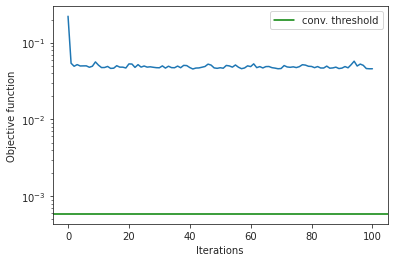

Run  0 failed, trying new initialization...
 77%|████████████████████████████████▎         | 77/100 [00:14<00:04,  5.44it/s]


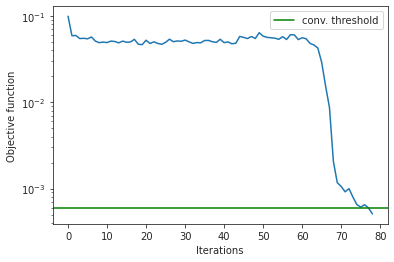

Initialization successful, improving estimate over full data....
100%|███████████████████████████████████████████| 40/40 [00:09<00:00,  4.03it/s]
#################
	 Convergence criterion satisfied
	 Final objective function value 0.00015877414221927077 with # of initializations: 2 
 	 Total runtime: 42.496318340301514


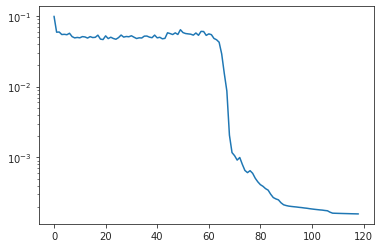

Time: 42.62100386619568


In [46]:
bsize = 50   # The batch size on which the optimization is started
t = time.time()
K,X,E,rho,res_list = run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
                     max_inits = 10, max_iter = 100, final_iter = 40, threshold_multiplyer = 30, 
                     target_rel_prec = 1e-4, testing = True)
#     plt.semilogy(res_list)   # plot the objective function over the iterations
# print('MVE:', MVE(X_true,E_true,rho_true,X,E,rho,d,l, n_povm)[0])   # output the final mean variation error
plt.semilogy(res_list)
plt.show()

print('Time:', time.time()-t)

In [56]:
######################################    
# filename = 'full_rank_full_data'
# parameters = {'sequence length':l,'gate count':d,'Kraus rank':rK,'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J,'y':y,'threshold_multiplyer': 30, 
#                      'target_rel_prec':1e-4}
# results = {'X':X,'E':E,'rho':rho, 'res_list':res_list}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
with open(filename, 'rb') as handle:
    b = pickle.load(handle)
ns_r = Namespace(**b['results'])

In [58]:
mdl = arrays_to_pygsti_model(ns_r.X,ns_r.E,ns_r.rho, basis = 'std')
X_t,E_t,rho_t = pygsti_model_to_arrays(std.target_model(),basis = 'std')
target_mdl = arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std')

gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, 'pp'),
            item_weights={'G0': 1,'G1': 1,'G2': 1, 'spam': 0})

X_opt,E_opt,rho_opt = pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

In [59]:
def diamond_dists(model1,model2,pdim, basis_string = 'pp'): 
    gate_dists = []
    basis = pygsti.baseobjs.Basis.cast(basis_string,pdim**2)
    labels1 = [label for label in model1.__dict__['operations'].keys()]
    labels2 = [label for label in model2.__dict__['operations'].keys()]
    
    for i in range(len(labels1)):
        gate_dists.append(float(rptbl.half_diamond_norm(model1[labels1[i]], model2[labels2[i]], basis)))
    return np.array(gate_dists)

In [60]:
print(gauge_optimized_mdl)
print(target_mdl)

rho0 = FullState with dimension 4
 0.71 0.02 0.01 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.70   0   0 0.61

1: FullPOVMEffect with dimension 4
 0.72   0   0-0.61



G0 = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 0.99   0
   0   0   0 0.99


G1 = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0-0.02-0.99
   0   0 0.99-0.02


G2 = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
 0.01-0.01   0 0.98
   0   0 0.97   0
   0-0.98   0-0.01




rho0 = FullState with dimension 4
 0.71   0   0 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: FullPOVMEffect with dimension 4
 0.71   0   0-0.71



G0 = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


G1 = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0-1.00
   0   

In [61]:
print(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))

0.06644582751917015


In [62]:
print('MVE:', MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])   # output the final mean variation error
print(average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
print(diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))

MVE: 0.04392920814358418
[0.99543664 0.99671699 0.98741156]
[0.00864007 0.01542168 0.02284026]


Things to check out:
- Run on first 50/100 sequences, then on next 50/100 etc. to see changes over time in the experiment
- Run for ranks 1-4 and see fit quality and compare high rank low rank projections with low rank estimates
- Optimize for average gate fidelity computing time